In [2]:
"""
Two-Body System Analysis
Investigating the central mass in Omega Centauri
Comparing acceleration vs velocity
"""

'\nTwo-Body System Analysis\nInvestigating the central mass in Omega Centauri\nComparing acceleration vs velocity\n'

In [3]:
"""
Timer
"""
import time
start_time = time.time()

In [4]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from PyAstronomy import pyasl
import astropy.units as u
import astropy.constants as const
import pandas as pd
import matplotlib.lines as mlines
from astropy.table import Table
from datetime import datetime
from scipy import stats
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar


import two_body_utils_2 as utils


In [5]:
print(utils.m_primary)
print(utils.semi_major_sample.to(u.au))
print(utils.n_int)

50000
2714.9999999999995 AU
10000


In [6]:
"""
Observed 2D Velocities and Accelerations 
----------------------------------------
Observational data for 7 high-velocity stars in Omega Centauri
Calculations of plane-of-sky accelerations and propagation of uncertainties
"""

# ========================================================
# 1. Input: Measured Proper Motion Velocities (v2D)
# ========================================================

# 2D velocities in the plane of the sky [km/s]
# Sources A–G
v2D = np.array([113.0, 66.6, 94.9, 77.9, 69.6, 67.4, 66.2]) * u.km / u.s

# Corresponding 1σ uncertainties [km/s]
v2D_err = np.array([1.1, 4.1, 1.7, 2.0, 0.8, 0.4, 1.9]) * u.km / u.s

# ========================================================
# 2. Input: Angular Accelerations from Astrometry (RA/Dec)
# ========================================================

# Accelerations in Right Ascension [mas/yr²]
a_ra = np.array([-0.0069, 0.0702, 0.0028, 0.0357, 0.0072, 0.0052, -0.0197]) * u.mas / u.yr**2
a_ra_err = np.array([0.0083, 0.0239, 0.0333, 0.0177, 0.0042, 0.0038, 0.0267]) * u.mas / u.yr**2

# Accelerations in Declination [mas/yr²]
a_dec = np.array([0.0085, 0.0228, -0.0060, -0.0194, -0.0009, -0.0015, 0.0173]) * u.mas / u.yr**2
a_dec_err = np.array([0.0098, 0.0157, 0.0123, 0.0162, 0.0075, 0.0038, 0.0170]) * u.mas / u.yr**2

# ========================================================
# 3. Total Angular Acceleration and Uncertainty (Plane-of-Sky)
# ========================================================

# Total angular acceleration [mas/yr²]
a_total_masyr2 = np.sqrt(a_ra**2 + a_dec**2)

# Propagate uncertainty using partial derivatives
a_total_masyr2_err = np.sqrt(
    (a_ra * a_ra_err / a_total_masyr2)**2 +
    (a_dec * a_dec_err / a_total_masyr2)**2
)

# ========================================================
# 4. Conversion to Physical Acceleration [km/s²]
# ========================================================

# Convert angular acceleration to physical acceleration using cluster distance
a_total = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2, distance_km=utils.distance_km)
a_total_err = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2_err, distance_km=utils.distance_km)

# ========================================================
# 5. Create Summary Data Table
# ========================================================

# Build astropy table of all values
star_data = Table({
    "v2D": v2D,
    "v2D_err": v2D_err,
    "a_ra": a_ra,
    "a_ra_err": a_ra_err,
    "a_dec": a_dec,
    "a_dec_err": a_dec_err,
    "a_total": a_total,
    "a_total_err": a_total_err,
})

# Final table 
star_data


v2D,v2D_err,a_ra,a_ra_err,a_dec,a_dec_err,a_total,a_total_err
km / s,km / s,mas / yr2,mas / yr2,mas / yr2,mas / yr2,km / s2,km / s2
float64,float64,float64,float64,float64,float64,float64,float64
113.0,1.1,-0.0069,0.0083,0.0085,0.0098,8.930061383293236e-09,7.531455373299496e-09
66.6,4.1,0.0702,0.0239,0.0228,0.0157,6.02047938832453e-08,1.8958529783912896e-08
94.9,1.7,0.0028,0.0333,-0.006,0.0123,5.400731419743836e-09,1.4649029465648002e-08
77.9,2.0,0.0357,0.0177,-0.0194,0.0162,3.314142014778814e-08,1.4167818247443028e-08
69.6,0.8,0.0072,0.0042,-0.0009,0.0075,5.918566003817241e-09,3.483038561817065e-09
67.4,0.4,0.0052,0.0038,-0.0015,0.0038,4.4144539757184885e-09,3.0995661122692196e-09
66.2,1.9,-0.0197,0.0267,0.0173,0.017,2.1385320005943142e-08,1.8748565257835362e-08


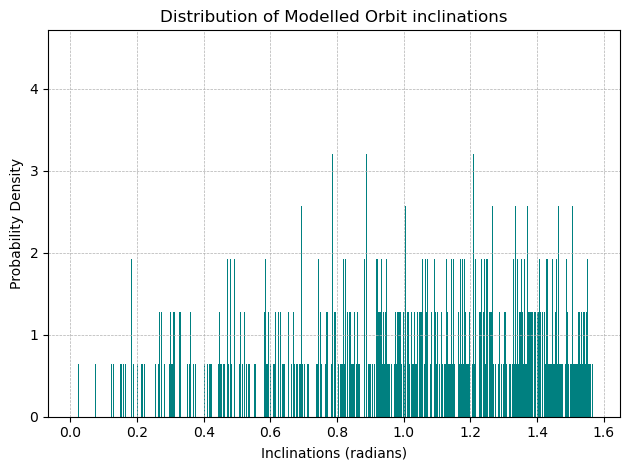

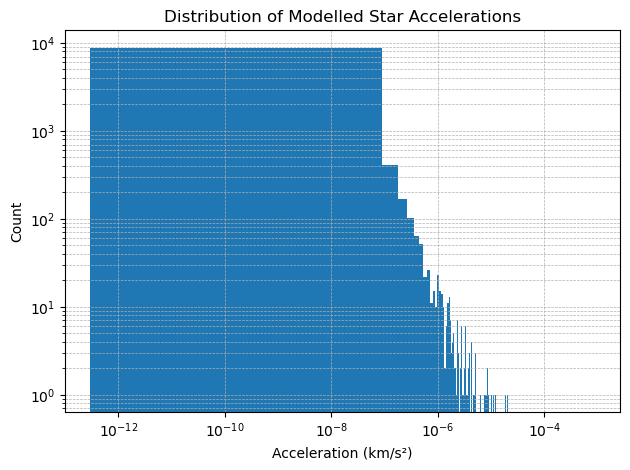

In [8]:
"""
Binary Orbit Calculations (m_primary; f(e) = 2e; nu; i = arccos(u))
"""

# ========================================================
# 1. Sample Eccentricities, Inclinations and Mean Anomalies
# ========================================================

# Sample eccentricities from the thermal distribution f(e) = 2e using inverse transform sampling:
# Let p ~ Uniform(0,1), then e = sqrt(p) ensures f(e) ∝ 2e
p_i = np.random.uniform(0, 1, utils.n_int)
eccentricities_i = np.sqrt(p_i)

# Sample mean anomalies (M) uniformly from [0, 2π]
# This reflects uniform motion in time along each orbit
# Non-unifrom distribution of true annomaly is calculated later
mean_anomaly_i = np.random.uniform(0, 2*np.pi, utils.n_int)

# Sample inclinations by sampling uniform u=cos(i) from 0 to one, reflecting inclinations from zero to 90 degrees
u_inc = np.random.uniform(0, 1, utils.n_int)
inc_rad = np.arccos(u_inc)
# Convert to degrees for BinaryOrbit
inclinations_deg = np.degrees(inc_rad)

# ========================================================
# 2. Compute Eccentric and True Anomalies
# ========================================================

# Initialize an array to store eccentric anomalies (E)
# Shape: (n_eccentricities, n_mean_anomalies)
ecc_anomaly_i = np.zeros((utils.n_int))

# Solve Kepler's equation: M = E - e*sin(E) → E, for each (e, M) pair
for k, (e_val, m_anmly) in enumerate(zip(eccentricities_i, mean_anomaly_i)):
    ecc_anomaly_i[k] = utils.eccentric_annomaly(M=m_anmly, e=e_val)

# Initialize an array to store true anomalies (ν)
true_anomaly_i = np.zeros((utils.n_int))

# Convert each eccentric anomaly and eccentricity to true anomaly 
for k, (e_val, E_val) in enumerate(zip(eccentricities_i, ecc_anomaly_i)):
        true_anomaly_i[k] = utils.true_anomaly(E=E_val, e=e_val)

# ========================================================
# 3. Compute Orbital Distances from Center of Mass
# ========================================================

# Compute instantaneous radial distance (r) from center of mass
# for the primary and secondary components in meters
a_primary_i = np.zeros((utils.n_int))
for k, (e_val, t_anmly) in enumerate(zip(eccentricities_i, true_anomaly_i)):
    a_primary_i[k] = utils.com_radius(a=utils.semi_major_primary.to(u.m).value, e=e_val, nu=t_anmly)     #m
    
a_secondary_i = np.zeros((utils.n_int))
for k, (e_val, t_anmly) in enumerate(zip(eccentricities_i, true_anomaly_i)):
    a_secondary_i[k] = utils.com_radius(a=utils.semi_major_secondary.to(u.m).value, e=e_val, nu=t_anmly)    #m

# Compute the separation (r) in meters between the two bodies at each true anomaly
relative_distance_i = np.zeros((utils.n_int))
for k, (a_pri, a_sec, e_val, t_anmly) in enumerate(zip(a_primary_i, a_secondary_i, eccentricities_i, true_anomaly_i)):
    relative_distance_i[k] = utils.relative_distance(a_primary=a_pri, a_secondary=a_sec, e=e_val, nu=t_anmly)



# ========================================================
# 4. Compute XY-Plane Accelerations and speed with utils
# ========================================================

# The acceleration of the secondary body in the plane of the sky
# Units outputted: km/s² (but requires input distances in meters)
# a_xy_i = utils.xy_orbital_acceleration_secondary(rd=relative_distance_i, i = inc_rad).value
a_xy_i = utils.xy_orbital_acceleration_secondary(rd=relative_distance_i*u.m, i = inc_rad).value

# The Orbital velocity of the secondary
# Units outputted: m/s (requires input distances in meters)
# Note: CANNOT convert to velocity in the plane of the sky using cos(inc_rad) ==== approximation works for inclination = 0 only!!!
# This is useful for calculating the orbital period
orbital_speed_i = np.zeros((utils.n_int))*u.m/u.s
for k, (a_sec, e_val, t_anmly) in enumerate(zip(a_secondary_i*u.m, eccentricities_i, true_anomaly_i)):
    orbital_speed_i[k] = utils.orbital_speed(a = a_sec, e = e_val, nu=t_anmly)


# ========================================================
# 4. Compute Orbital Velocity with BinaryOrbit
# ========================================================

# Orbital period in days using a_secondary_i (in meters) orbital_speed in m/s
per_i_days = np.zeros(utils.n_int) * u.day
for k, (a_sec, v_orb) in enumerate(zip(a_secondary_i, orbital_speed_i)):
    per_i_days[k] = utils.orbital_period_days(semi_major = a_sec*u.m, speed= v_orb)
    
# Calculate timesteps from true anomalies in seconds
t_i = np.zeros((utils.n_int))*u.s
for k, (a_sec, e_val, t_anmly) in enumerate(zip(a_secondary_i*u.m, eccentricities_i, true_anomaly_i)):
    t_i[k]= utils.true_anomaly_to_time(nu = t_anmly, e = e_val, a = a_sec)

# Convert timesteps to days to compare with period in days
t_i_days = t_i.to(u.day)

# Initialize empty array for velocities of primary (1) and secondary (2) bodies in the binary orbit
v1_i = np.zeros((utils.n_int, 3))
v2_i = np.zeros((utils.n_int, 3))

for k, (e_val, i_val) in enumerate(zip(eccentricities_i, inclinations_deg)):
        # Create BinaryOrbit instance for current e and i
        bo = pyasl.BinaryOrbit(
            m2m1 = utils.m2m1,               # Mass ratio (m2/m1)
            mtot = utils.mtot,               # Total mass (M_sun)
            per = per_i_days.value[k],              # Period in days
            e = e_val,                       # Sampled eccentricity
            tau = utils.tau,                 # Time of periastron (d)
            Omega = utils.Omega,             # Ascending node longitude (deg)
            w = utils.w,                     # Argument of periapsis (deg)
            i=i_val                          # Inclination (deg)
        )

        # Wrap time to [0, period) to avoid going beyond one orbit
        t_i_wrapped = (t_i_days[k] % per_i_days[k]).to(u.s).value  # In seconds, scalar
    
        # Compute velocities at each timestep
        v1_i[k], v2_i[k] = bo.xyzVel(t_i_wrapped)


# Velocity magnitude in XY-plane (m/s)
v1_xy_i = np.linalg.norm(v1_i[:, :2], axis=1)
v2_xy_i = np.linalg.norm(v2_i[:, :2], axis=1)

# ========================================================
# 5. Plot the Distributions
# ========================================================

# Plot histogram of inclinations in radians
plt.hist(inc_rad.flatten(), bins= utils.n_int, density=True, color='teal')
plt.xlabel('Inclinations (radians)')
plt.ylabel('Probability Density')
plt.title('Distribution of Modelled Orbit inclinations')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot histogram of orbital accelerations
plt.hist(a_xy_i.flatten(), bins= utils.n_int, log=True)
plt.xscale("log")  # Logarithmic x-axis due to wide range of accelerations
plt.xlabel('Acceleration (km/s²)')
plt.ylabel('Count')
plt.title('Distribution of Modelled Star Accelerations')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


C:\Users\macke\AppData\Local\Temp\ipykernel_8976\1654205002.py:163: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


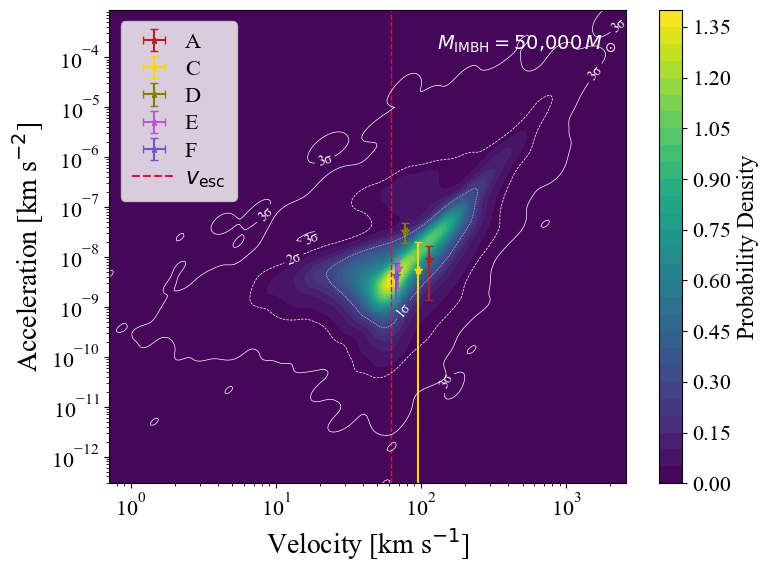

In [13]:
"""
Kernel Density Estimate of Calculated Stars 
"""

# ========== Style Settings ==========
plt.rcParams.update({ # Setting font sizes for plot elements
    "font.size": 16,
    "font.family": "Times New Roman",   
    "axes.titlesize": 20,
    "axes.labelsize": 17,
    "legend.fontsize": 17,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "figure.titlesize": 16
})

# ========== Set Up Plot ==========
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel(r"Velocity [km s$^{-1}$]", fontsize=20)
ax.set_ylabel(r"Acceleration [km s$^{-2}$]", fontsize=20)
# plt.title(fr"Acceleration vs Velocity ({utils.m_primary:,} $M_{{\odot}}$)")

# Alternte Title: ({utils.m_primary:,}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u))

ax.set_xscale("log")
ax.set_yscale("log")

# ========== Add IMBH Mass Annotation ==========
mass_label = f"{utils.m_primary:,}"  # "50,000"

ax.text(
    0.98, 0.95,
    fr"$M_{{\mathrm{{IMBH}}}} = \text{{{mass_label}}}\,M_\odot$",
    transform=ax.transAxes,
    fontsize=14,
    fontfamily="Times New Roman",
    ha="right", va="top",
    color="white",
)

# ========== Plot Observed Stars with Error Bars ==========

colours = ["firebrick", "darkorange", "gold", "olive", "mediumorchid", "slateblue", "powderblue", "thistle"]

labels = ["A", "B", "C", "D", "E", "F", "G"]

skip = {"B", "G"}   # stars you don’t want
for i, label in enumerate(labels):
    if label in skip:
        continue  # skip plotting this star
    plt.errorbar(
        x=v2D[i].value,
        y=a_total[i].value,
        xerr=v2D_err[i].value,
        yerr=a_total_err[i].value,
        fmt="*",
        label=label,
        color=colours[i],
        capsize=3
    )

# ========== Plot Escape Velocity Threshold ==========
ax.axvline(x=62, color='crimson', linestyle='--', linewidth=1)

# ========== KDE for Simulated Stars ==========
velocities = v2_xy_i.flatten() / 1e3        # velocities in km/s
accelerations = a_xy_i.flatten()            # accelerations in km/s²

log_velocities = np.log10(velocities)
log_accelerations = np.log10(accelerations)

values = np.vstack([log_velocities, log_accelerations])

# Create grid in log-log space
x_grid, y_grid = np.mgrid[
    log_velocities.min():log_velocities.max():200j,
    log_accelerations.min():log_accelerations.max():200j
]

positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, x_grid.shape)

# Convert back to linear space for plotting
X_plot = 10 ** x_grid
Y_plot = 10 ** y_grid

# KDE contour plot (no scatter of simulated stars shown)
contour = plt.contourf(X_plot, Y_plot, Z, levels=30, cmap='viridis', alpha=1.0)

# ========== Overlay 1σ, 2σ, 3σ Contours ==========

# Flatten KDE values and sort
Z_flat = Z.ravel()
Z_sorted = np.sort(Z_flat)[::-1]
cumulative = np.cumsum(Z_sorted) / Z_sorted.sum()      # normalise to 1

# Target (1–2–3 σ) probability mass levels
sigma_probs = [0.68, 0.95, 0.997]

# KDE thresholds that enclose those masses
contour_values = [Z_sorted[np.searchsorted(cumulative, p)] for p in sigma_probs]

# Strictly increasing
contour_values = np.unique(np.round(contour_values, decimals=12))  

# Ensure contour_values are strictly increasing for Matplotlib
contour_values = np.sort(contour_values)

# Draw contour lines
sigma_contours = plt.contour(
    X_plot, Y_plot, Z,
    levels=contour_values,
    colors='white',
    linewidths=0.5,
    linestyles=['-', '--', ':'],
)

# Correct labels in increasing order
fmt = {
    contour_values[0]: '3σ',  # outermost, lowest density
    contour_values[1]: '2σ',
    contour_values[2]: '1σ',  # innermost, highest density
}
plt.clabel(sigma_contours, fmt=fmt, fontsize=10)

# Add colorbar to explain shading
cbar = plt.colorbar(contour)
cbar.set_label("Probability Density")

# ========== Legend Handling ==========
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None',
                            label=fr"{utils.m_primary:,}$M_{{\odot}}$")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label=r"$v_{\mathrm{esc}}$")

handles, legend_labels = plt.gca().get_legend_handles_labels()
handles.extend([escape_vel_line])
legend_labels.extend([r"$v_{\mathrm{esc}}$"])

ax.legend(
    handles=handles,
    labels=legend_labels,
    fontsize=16,
    loc='best',
    markerscale=0.8,
    handletextpad=0.4,
    borderpad=0.5,
    labelspacing=0.3
)

# ========== Plot Limits ==========

# plt.xlim(10, 250)    # Limits for velocity (km/s)
# plt.ylim(1e-11, 1e-5)   # Limits for acceleration (km/s²)

# ========== Save and Show ==========
i_plot_name = f"Acceleration_vs_Velocity_{utils.m_primary}_KDE"
i_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
i_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\octo_orbit\two_body_plots\{i_plot_name}_{i_timestamp}.png"

fig.tight_layout()
fig.savefig(i_filename, bbox_inches="tight", pad_inches=0.1)
fig.show()

In [ ]:
"""
End Timer
"""
end_time = time.time()
total_time = end_time - start_time

minutes, seconds = divmod(total_time, 60)
print(f"Total runtime: {int(minutes)} min {seconds:.2f} sec")

Total runtime: 62 min 37.42 sec


In [ ]:
# """
# Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars (m_primary; f(e) = 2e; nu: i = arccos(u))
# """

# # Plot
# plt.figure(figsize=(8, 6))
# plt.xlabel("Velocity [km/s]")
# plt.ylabel("Acceleration [km/s²]")
# plt.title(fr"Acceleration vs Velocity ({utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u))")

# plt.xscale("log")
# plt.yscale("log")

# # ========== Plot Observed Stars with Error Bars ==========

# # Colour and label settings for stars A–G
# colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
# labels = ["A", "B", "C", "D", "E", "F", "G"]

# # Plot each star with error bars (1σ in velocity and acceleration)
# for i in range(len(colours)):
#     plt.errorbar(
#         x=v2D[i].value,
#         y=a_total[i].value,
#         xerr=v2D_err[i].value,
#         yerr=a_total_err[i].value,
#         fmt="*",
#         label=labels[i],
#         color=colours[i],
#         capsize=3
#     )

# # ========== Plot Simulated Binary Stars ==========

# # Simulated secondary stars' velocities and accelerations
# plt.plot(v2_xy_i.flatten() / 1e3, a_xy_i.flatten(), '*', color="midnightblue")

# # ========== Plot Escape Velocity Threshold ==========

# av_escape_velocity = 62  # km/s average escape velocity
# plt.axvline(
#     x=av_escape_velocity,
#     color='crimson',
#     linestyle='--',
#     linewidth=1
# )

# # ========== Legend Handling ==========

# # Custom handles for legend
# sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None',
#                             label=fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)")
# escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# # Collect current legend entries (A–G)
# handles, legend_labels = plt.gca().get_legend_handles_labels()

# # Add custom entries
# handles.extend([sample_star, escape_vel_line])
# legend_labels.extend([fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)", 'Escape Velocity'])

# # Final legend
# plt.legend(handles=handles, labels=legend_labels)


# # ========== Save Plot ==========

# # Create a timestamped filename for saving the plot
# i_plot_name = f"Acceleration_vs_Velocity_{utils.m_primary}_fe=2e_nu_i_"
# i_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# i_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\octo_orbit\two_body_plots\{i_plot_name}_{i_timestamp}.png"


# # ========== Summary Table ========== 

# summary_table_i = pd.DataFrame({
#     "Eccentricity": eccentricities_i,
#     "Inclination (rad)": inc_rad,
#     "True Anomaly (rad)": true_anomaly_i,
#     "Timestep (days)": t_i_days,
#     "Relative Distance (km)": relative_distance_i,
#     "XY Acceleration (km/s²)": a_xy_i,
#     "XY Velocity (km/s)": v2_xy_i/1e3
# })

# # Get rows with max and min acceleration
# max_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmax()]
# min_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmin()]

# # Get rows with max and min velocity
# max_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmax()]
# min_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmin()]

# # Label the rows for clarity
# max_acc_row["Label"] = "Max Acceleration"
# min_acc_row["Label"] = "Min Acceleration"
# max_vel_row["Label"] = "Max Velocity"
# min_vel_row["Label"] = "Min Velocity"

# # Fill the rest with empty strings to avoid NaNs
# summary_table_i["Label"] = ""

# # Create a new DataFrame for the labeled rows
# top_rows = pd.DataFrame([max_acc_row, min_acc_row, max_vel_row, min_vel_row])

# # Concatenate labeled top rows with the full table
# summary_table_i = pd.concat([top_rows, summary_table_i], ignore_index=True)

# # Display table
# # Save and show the plot
# plt.savefig(i_filename)
# plt.show()
# summary_table_i


In [ ]:
# """
# Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars with Kernel Density Estimate
# (m_primary; f(e) = 2e; nu: i = arccos(u))
# """

# # Plot
# plt.figure(figsize=(8, 6))
# plt.xlabel("Velocity [km/s]")
# plt.ylabel("Acceleration [km/s²]")
# plt.title(fr"Acceleration vs Velocity with KDE ({utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u))")

# plt.xscale("log")
# plt.yscale("log")

# # ========== Plot Observed Stars with Error Bars ==========

# # Colour and label settings for stars A–G
# colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
# labels = ["A", "B", "C", "D", "E", "F", "G"]

# # Plot each star with error bars (1σ in velocity and acceleration)
# for i in range(len(colours)):
#     plt.errorbar(
#         x=v2D[i].value,
#         y=a_total[i].value,
#         xerr=v2D_err[i].value,
#         yerr=a_total_err[i].value,
#         fmt="*",
#         label=labels[i],
#         color=colours[i],
#         capsize=3 
#     )


# # ========== Plot Simulated Binary Stars ==========

# # Simulated secondary stars' velocities and accelerations
# plt.plot(v2_xy_i.flatten() / 1e3, a_xy_i.flatten(), '*', color="midnightblue", alpha=0.2)

# # ========== Plot Escape Velocity Threshold ==========

# av_escape_velocity = 62  # km/s average escape velocity
# plt.axvline(
#     x=av_escape_velocity,
#     color='crimson',
#     linestyle='--',
#     linewidth=1
# )

# # ========== Kernel Density Estimate (KDE) for Simulated Stars ========== 

# # Convert velocities from m/s to km/s by dividing by 1000
# velocities = v2_xy_i / 1e3         # velocities in km/s
# accelerations = a_xy_i            # accelerations in km/s²

# # Take the base-10 logarithm of the velocities and accelerations
# # This is needed because the plot is on a log-log scale
# log_velocities = np.log10(velocities).flatten()        # log₁₀(velocity)
# log_accelerations = np.log10(accelerations).flatten()    # log₁₀(acceleration)

# # Stack the log-transformed data into a 2D array
# # This format is required by the KDE function
# # Shape will be (2, N), where N is the number of data points
# values = np.vstack([log_velocities, log_accelerations])

# # Create a grid of (x, y) positions where the KDE will be evaluated
# # 100j means 100 grid points in each direction
# x_grid, y_grid = np.mgrid[
#     log_velocities.min():log_velocities.max():100j,
#     log_accelerations.min():log_accelerations.max():100j
# ]

# # Flatten the grid and stack it for input to the KDE function
# # Each column is a 2D point: [log_velocity, log_acceleration]
# positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# # Kernel density estimate (KDE)
# # This estimates the probability density function based on the data
# kernel = stats.gaussian_kde(values)

# # Evaluate the KDE on the grid and reshape the result
# # Z will be a 2D array representing the estimated density at each grid point
# Z = np.reshape(kernel(positions).T, x_grid.shape)

# # Convert the log-space grid back to linear values for plotting
# # This matches the original log-log plot scale
# X_plot = 10 ** x_grid
# Y_plot = 10 ** y_grid

# # Plot the KDE as a filled contour plot
# # levels=30 means 30 contour levels (the number of shaded bands)
# # alpha=0.5 makes the plot semi-transparent so points underneath are still visible
# contour = plt.contourf(X_plot, Y_plot, Z, levels=30, cmap='BuPu', alpha=1)

# # Add a colorbar to show the density scale
# cbar = plt.colorbar(contour)
# cbar.set_label("Estimated Probability Density")

# # ========== Legend Handling ==========

# # Custom handles for legend
# sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None',
#                             label=fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)")
# escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# # Collect current legend entries (A–G)
# handles, legend_labels = plt.gca().get_legend_handles_labels()

# # Add custom entries
# handles.extend([sample_star, escape_vel_line])
# legend_labels.extend([fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)", 'Escape Velocity'])

# # Final legend
# plt.legend(
#     handles=handles,
#     labels=legend_labels,
#     fontsize=8,               # Smaller text
#     loc='best',               # Auto-place in best spot
#     markerscale=0.8,          # Scale down markers
#     handletextpad=0.4,        # Space between marker and text
#     borderpad=0.5,            # Padding inside the legend box
#     labelspacing=0.3          # Space between legend entries
# )


# # ========== Save Plot ==========

# # Create a timestamped filename for saving the plot
# i_plot_name = f"Acceleration_vs_Velocity_{utils.m_primary}_fe=2e_nu_i_KDE_"
# i_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# i_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\octo_orbit\two_body_plots\{i_plot_name}_{i_timestamp}.png"


# # ========== Summary Table ========== 

# summary_table_i = pd.DataFrame({
#     "Eccentricity": eccentricities_i,
#     "Inclination (rad)": inc_rad,
#     "True Anomaly (rad)": true_anomaly_i,
#     "Timestep (days)": t_i_days,
#     "Relative Distance (km)": relative_distance_i,
#     "XY Acceleration (km/s²)": a_xy_i,
#     "XY Velocity (km/s)": v2_xy_i/1e3
# })

# # Get rows with max and min acceleration
# max_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmax()]
# min_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmin()]

# # Get rows with max and min velocity
# max_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmax()]
# min_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmin()]

# # Label the rows for clarity
# max_acc_row["Label"] = "Max Acceleration"
# min_acc_row["Label"] = "Min Acceleration"
# max_vel_row["Label"] = "Max Velocity"
# min_vel_row["Label"] = "Min Velocity"

# # Fill the rest with empty strings to avoid NaNs
# summary_table_i["Label"] = ""

# # Create a new DataFrame for the labeled rows
# top_rows = pd.DataFrame([max_acc_row, min_acc_row, max_vel_row, min_vel_row])

# # Concatenate labeled top rows with the full table
# summary_table_i = pd.concat([top_rows, summary_table_i], ignore_index=True)

# # Display table
# # Save and show the plot
# plt.savefig(i_filename)
# plt.show()
# summary_table_i
